# AI기법과 활용 - Week 09
RNN 기본
- https://wikidocs.net/44249
____

## 데이터 준비

In [ ]:
import sys
!{sys.executable} -m pip install konlpy
!pip install konlpy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
!wget -O ratings_train.txt https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget -O ratings_test.txt https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2022-07-16 08:10:12--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  11.1MB/s    in 1.3s    

2022-07-16 08:10:15 (11.1 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2022-07-16 08:10:16--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Savin

In [3]:
train_data = pd.read_csv('ratings_train.txt',sep="\t")
test_data = pd.read_csv('ratings_test.txt',sep="\t")

## 전처리 - 결측값 제거

In [4]:
train_data = train_data.dropna(how = 'any')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 전처리 - 한글만 추출

In [5]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


## 전처리 - 공백 제거

In [6]:
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')
print(len(train_data))

148740


## 전처리 - 테스트 셋에 대해서도 동일한 과정 진행

In [7]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


## 불용어 정의

In [8]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


## 토큰화

In [9]:
X_train = []
okt = Okt()

for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 148740/148740 [06:38<00:00, 373.55it/s]


In [10]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [02:40<00:00, 304.14it/s]


## 토크나이저 세팅: Ordinal Encoding

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [12]:
print(tokenizer.word_index)


{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '재밌다': 11, '되다': 12, '적': 13, '만': 14, '같다': 15, '진짜': 16, '로': 17, '아니다': 18, '않다': 19, '점': 20, '에서': 21, '만들다': 22, '나오다': 23, '연기': 24, '평점': 25, '것': 26, '최고': 27, '내': 28, '그': 29, '나': 30, '안': 31, '인': 32, '스토리': 33, '생각': 34, '못': 35, '왜': 36, '드라마': 37, '게': 38, '감동': 39, '사람': 40, '보고': 41, '이렇다': 42, '말': 43, '아깝다': 44, '고': 45, '더': 46, 'ㅋㅋ': 47, '배우': 48, '때': 49, '아': 50, '재미있다': 51, '감독': 52, '거': 53, '그냥': 54, '요': 55, '재미': 56, '시간': 57, '내용': 58, '뭐': 59, '까지': 60, '중': 61, '주다': 62, '재미없다': 63, '자다': 64, '쓰레기': 65, '하고': 66, '지루하다': 67, '네': 68, '수': 69, '모르다': 70, '가다': 71, '들다': 72, '그렇다': 73, '싶다': 74, '지': 75, '작품': 76, '사랑': 77, '알다': 78, '하나': 79, '다시': 80, '볼': 81, '마지막': 82, '이건': 83, '정도': 84, '저': 85, '완전': 86, 'ㅋ': 87, '오다': 88, 'ㅠㅠ': 89, '많다': 90, 'ㅋㅋㅋ': 91, '처음': 92, '장면': 93, '액션': 94, '주인공': 95, '이렇게': 96, '걸': 97, '안되다': 98, '차다': 99, '최악': 100, '나다': 101, '개': 

## 전처리: 빈도수가 적은 단어 제거

In [13]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24328
단어 집합에서 희귀 단어의 비율: 55.604315231303715
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8637396855052155


In [14]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19425


In [15]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 빈 텍스트 제거 : 위의 공백제거에 의해 발생

In [17]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]


In [18]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

148509
148509


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Input Sequence Length 길이 결정

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.610959605141776


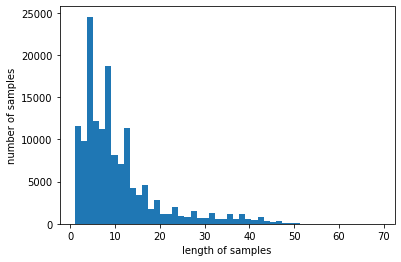

In [19]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [21]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.44612784410373


## Sequence 길이가 30보다 작은 문서는 빈 값으로 사이즈 맞추기
- Before: 1,2,3,4
- After: 0,0,0,0,,,,1,2,3,4

In [22]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, SimpleRNN, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

## 레이어 동작 방식 확인

In [50]:
input_array = np.random.randint(10, size=(1, 10)) #batch_size = 1, seq_len = 10
print(input_array)
emb = Embedding(10, 30) #vocab_size: 10, Embedding Size: 30
print(emb(0)) ## 0번째 단어에 대한 Embedding
print(emb(1)) ## 1번째 단어에 대한 Embedding
print(emb(input_array).shape)

[[0 6 6 3 8 3 6 8 0 3]]
tf.Tensor(
[ 0.03410916 -0.0155679  -0.00692321 -0.04792677 -0.0272534  -0.00363948
 -0.00134965 -0.03450364 -0.01584864  0.04758581 -0.02269768 -0.0023875
 -0.01778525  0.03263981 -0.03904388  0.034984   -0.04926499 -0.01889263
  0.02310587 -0.01489118 -0.01692575  0.02957573  0.04418346 -0.03172743
 -0.03953896  0.01898042  0.03839255 -0.01884421 -0.01863718 -0.00747472], shape=(30,), dtype=float32)
tf.Tensor(
[ 0.02160409 -0.04087619  0.03683287 -0.03603703 -0.01675873 -0.00693492
 -0.02371272 -0.02816662  0.0477283   0.03132768  0.0067596   0.01619646
 -0.01375296  0.04808531 -0.03850682 -0.02171478  0.03727042  0.00386842
 -0.02924523  0.018865   -0.04423275  0.0395859  -0.0385913   0.02562301
  0.01581403 -0.03723447 -0.04423841  0.01597141  0.03624917  0.03452298], shape=(30,), dtype=float32)
(1, 10, 30)


In [41]:
inputs = tf.random.normal([32, 10, 8]) #batch size, seq_length, embedding_size

rnn = SimpleRNN(20) #hidden_unit 또는 number of node in hidden layer
output = rnn(inputs)
print(output.shape)

(32, 20)


In [42]:
rnn = SimpleRNN(20,return_sequences=True) #hidden_unit 또는 number of node in hidden layer
output = rnn(inputs)
print(output.shape)

(32, 10, 20)


## 모델 정의 및 훈련

### 1. RNN

In [43]:


embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, callbacks=[es], batch_size=64, validation_split=0.2)

print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 100)         1942500   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 128)               29312     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,971,941
Trainable params: 1,971,941
Non-trainable params: 0
_________________________________________________________________
None
1527/1527 [==============================] - 3s 2ms/step - loss: 0.3776 - acc: 0.8357

 테스트 정확도: 0.8357


### 2. LSTM 

In [28]:


embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, callbacks=[es], batch_size=64, validation_split=0.2)

print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 8s 5ms/step - loss: 0.3609 - acc: 0.8401

 테스트 정확도: 0.8401


### 3. GRU

In [30]:


embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, callbacks=[es], batch_size=64, validation_split=0.2)

print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 6s 4ms/step - loss: 0.3565 - acc: 0.8425

 테스트 정확도: 0.8425
